# [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data?select=sales_train.csv)




## Library

In [1]:
# data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm # for loop bar
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# translator
from googletrans import Translator

## Description
- 과거의 판매 데이터. test 데이터를 이용하여 모든 가게에서 얼마나 팔리는지 예측 해야함. 매달 팔리는 양이 가게마다 제품마다 다름. 따라서 이를 수용하는 모델을 만들어야 함.
<br>

- Y = 특정 shop에 item_id 별로 팔리는 item_cnt_month   
=> 일별로 예측 후 합산 하거나 (2)   
=> 월별로 환산해서 나중에 합치는 방법 존재. (1)
<br>

- ID: an Id that represents a (Shop, Item) tuple within the test set
- shop_id: unique identifier of a shop **(60개)**
- item_id: unique identifier of a product **(22170개)**
- item_category_id: unique identifier of item category **(84개 카테고리)**
- item_cnt_day: number of products sold. You are predicting a monthly amount of this measure **(Y값)**
- item_price: current price of an item 
- date: date in format dd/mm/yyyy
- date_block_num: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name: name of item 
- shop_name: name of shop 
- item_category_name: name of item category

## Data Loading

In [2]:
item_cat = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales_train = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')

In [3]:
test = pd.read_csv('data/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
print(item_cat.head())
print(items.head())
print(sales_train.head())
print(shops.head())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00

## Russian -> English
- 데이터 해석을 쉽게 할 수 있도록 번역

In [6]:
# translator = Translator()

In [7]:
# # item_category_id
# item_cat['item_category_name_en'] = 'a'
# for i in range(len(item_cat)):
#     item_cat['item_category_name_en'][i] = translator.translate(item_cat['item_category_name'][i],src='ru',dest='en').text

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
# # item_category_id
# #items['item_name_en'] = items['item_name'].apply(lambda x: translator.translate(x, src='ru', dest='en').text )
# items['item_name_en'] = 'a'
# for i in range(5000):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text
# for i in range(5000,10000):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text
# for i in range(10000,15000):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text
# for i in range(15000,22171):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text

In [11]:
# 매번 번역 과정을 거치면 시간이 오래걸리므로.. 번역한 것 저장해서 사용.
# item_cat.to_csv('data/item_cat_en.csv')
# items.to_csv('data/item_en.csv')

## Data Exploration
### Data Check
#### NULL 값 확인 
- 없음 ^^

In [13]:
print(item_cat.isna().sum())
print(items.isna().sum())
print(sales_train.isna().sum())
print(shops.isna().sum())

item_category_name       0
item_category_id         0
item_category_name_en    0
dtype: int64
item_name           0
item_id             0
item_category_id    0
item_name_en        0
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64


- summary 확인
- item_price, item_cnt_day에 마이너스값 존재 => 이유 확인 필요

In [14]:
summary = sales_train.describe().round(3)
summary

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


#### item_cnt_day 확인
- item_cnt_day의 minus 값 확인 (7356개)
- 1) 환불 되었을 가능성 => 대충 확인이 가능함. 동일한 가격, shop, item 목록이 몇일 내에 존재한다면 확불로 추측. (논의 필요.)
- 2) 도난 되었을 가능성 => 확인할 방법이 없고 그냥 삭제
- 3) 오류일 가능성

In [20]:
sales_minus = sales_train[sales_train.item_cnt_day<0]
sales_minus

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


- 아래는 환불되었는지 확인하는 과정:    
환불을 받았으면 구매한 내역도 있을 것이라 추론.   
즉, shop_id와 item_id로 조회했을 때 기록이 2개 이상 나와야함.   
1개만 나오는 경우, 해당 데이터 이전에 구매했기 때문일 수도 있으므로 data_block_num이 모두 0이 되어야 함.   
<br>

- 하지만 확인 결과, 기록이 1개인 것이 25개가 존재하며, 이 중 data_block_num이 0이 아닌 것이 몇개 존재함.
- 따라서 그냥 삭제 처리함.

In [21]:
# check => 같은 shop_id, item_id값이 1개만 존재
# dictionary로 shop_id, item_id mapping
minus_l = []
minus = zip(sales_minus['shop_id'], sales_minus['item_id'])
minus = list(set(minus))
# unique shop_id, item_id
print(len(minus))
for i in range(len(minus)):
    minus_l.append(len(sales_train.loc[(sales_train['shop_id']==minus[i][0]) & (sales_train['item_id']==minus[i][1])]))
# 최소값 
min(minus_l)
#len(sales_train.loc[(sales_train['shop_id']==25) & (sales_train['item_id']==2552)])

6806


1

In [22]:
minus_l.count(1) # 25개 존재.

25

In [23]:
# 이전 날짜가 데이터에 없어서 잘린 걸수도 있으므로 date_block_num확인
# 모두 0이면 환불 데이터로 취급
# 쌩뚱맞은 것들이 있음. -> 그냥 마이너스는 다 삭제
minus_idx = [i for i, e in enumerate(minus_l) if e == 1]
minus_df = pd.DataFrame()
for i in minus_idx:
    minus_df = pd.concat([minus_df,sales_train.loc[(sales_train['shop_id']==minus[i][0]) & (sales_train['item_id']==minus[i][1]),['date_block_num','shop_id','item_id']]])
minus_df[minus_df.date_block_num!=0]

,date_block_num,shop_id,item_id
744566,7,42,13474
142796,1,16,18062
194977,1,41,6664
176750,1,12,15435
549457,5,46,13473
186255,1,32,6664
798185,7,16,13477
2859389,32,22,9255


In [24]:
# 마이너스값 삭제
sales_train = sales_train[sales_train.item_cnt_day>=0]

#### item_price 이상치 확인
- 어짜피 한 개 이므로 삭제

In [16]:
item_p_minus = sales_train[sales_train.item_price<=0]
item_p_minus

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [17]:
sales_train = sales_train[sales_train.item_price>0]

In [26]:
# Describe 다시 확인
summary = sales_train.describe().round(3)
summary

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2928492.000,2928492.000,2928492.000,2928492.000,2928492.000
mean,14.570,33.003,10200.282,889.467,1.248
std,9.423,16.225,6324.396,1727.499,2.620
min,0.000,0.000,0.000,0.070,1.000
25%,7.000,22.000,4477.000,249.000,1.000
50%,14.000,31.000,9355.000,399.000,1.000
75%,23.000,47.000,15691.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


- 데이터 month별로 환산

In [27]:
sales_month = sales_train.groupby(['date_block_num','shop_id','item_id'], as_index=False)['item_cnt_day'].agg('sum')
sales_month

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1608221,33,59,22087,6.0
1608222,33,59,22088,2.0
1608223,33,59,22091,1.0
1608224,33,59,22100,1.0


In [38]:
sales_month = sales_month.rename(columns = {"item_cnt_day":"item_cnt_month"}) 

#### Distribution 확인
- 치우친값이 있는지.

In [ ]:
# fill

- 각 카테고리 별 아이템 갯수
- 각 가게 별 카테고리 갯수, 아이템 갯수

- month별로 가장 많이 팔린 아이템 비교

In [ ]:
# fill

In [36]:
# sales_month에 item_category_en, item_en 붙이기
sales_month=sales_month.merge(items[['item_id','item_name_en','item_category_id']],
                 on = 'item_id',
                 how = 'left')

sales_month=sales_month.merge(item_cat[['item_category_id','item_category_name_en']], 
                  on = 'item_category_id',
                 how = 'left')

sales_month

,date_block_num,shop_id,item_id,item_cnt_day,item_name_en,item_category_id,item_category_name_en
0,0,0,32,6.0,1 + 1,40,Movie - DVD
1,0,0,33,3.0,1 + 1 (BD),37,Cinema - Blu-Ray
2,0,0,35,1.0,10 YEARS LATER,40,Movie - DVD
3,0,0,43,1.0,100 MILLION EUROS,40,Movie - DVD
4,0,0,51,2.0,Top 100 Classics (mp3-CD) (Digipack),57,Music - MP3
...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,Battery DURACELL LR03-BC2,83,Batteries
1608222,33,59,22088,2.0,Элемент питания DURACELL LR06-BC2,83,Batteries
1608223,33,59,22091,1.0,Battery DURACELL TURBO LR 03 2 * BL,83,Batteries
1608224,33,59,22100,1.0,Adventure Time Encyclopedia,42,"Books - Artbooks, encyclopedias"


- 매출이 좋은 가게 확인

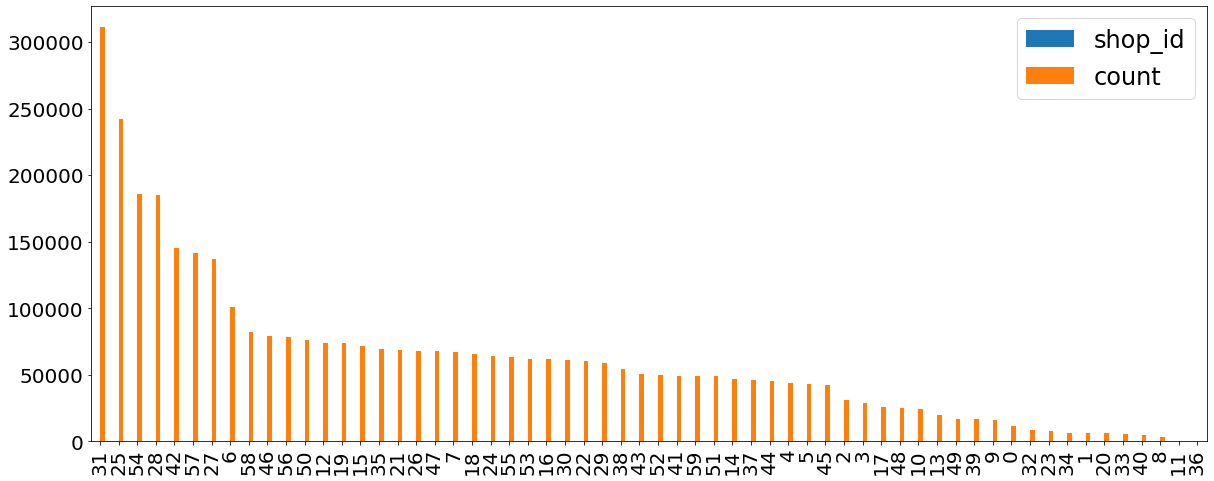

In [58]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.size'] = 20
sales_month.groupby(['shop_id'])['item_cnt_month'].sum().reset_index(name='count').sort_values(['count'], ascending=False).plot(kind='bar')
plt.show()

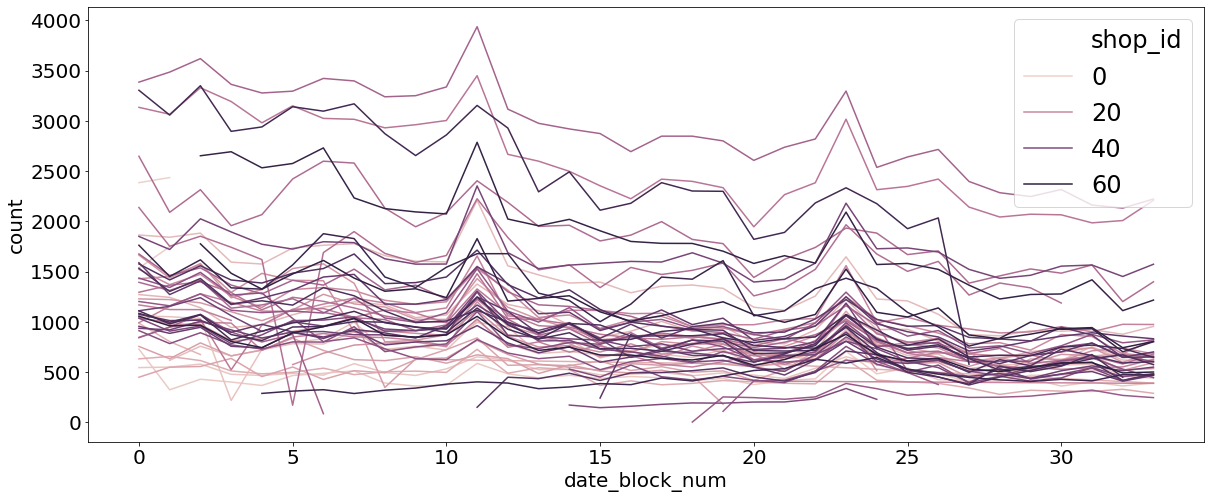

In [85]:
# 가게들 추세 확인 -> 어떤 가게는 계속 잘팔리고 어떤 가게는 계속 잘 안팔리는 경향?
# 대충 보면 추세는 얼추 비슷하게 가는 편. (어쩌다가 갑자기 하락하는 경우도 있긴 함)
sales_shop_check = sales_month.groupby(['date_block_num','shop_id'])['item_id']\
            .count()\
            .reset_index(name='count')

sns.lineplot(x="date_block_num",y="count",hue="shop_id",
            units="shop_id",data=sales_shop_check, estimator=None)

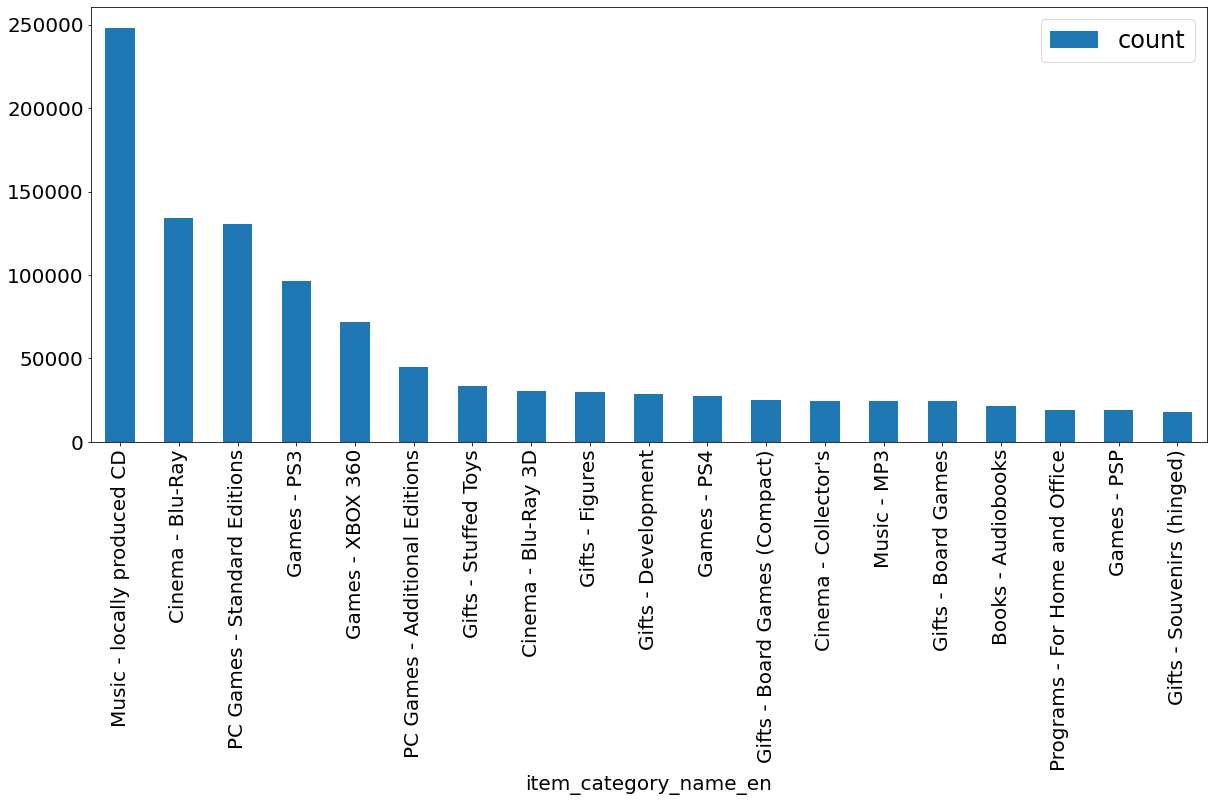

In [65]:
# 통틀어서 가장 많이 팔린 카테고리 확인 (상위 10개)
sales_month.groupby(['item_category_name_en'])['item_name_en']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]\
            .plot.bar(x='item_category_name_en',y='count')
#.plot(kind='bar')
plt.show()

In [91]:
# 상위 20개의 추세 알아보기
top20_item = sales_month.groupby(['item_category_name_en'])['item_name_en']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]['item_category_name_en']

['Music - locally produced CD',
 'Cinema - Blu-Ray',
 'PC Games - Standard Editions',
 'Games - PS3',
 'Games - XBOX 360',
 'PC Games - Additional Editions',
 'Gifts - Stuffed Toys',
 'Cinema - Blu-Ray 3D',
 'Gifts - Figures',
 'Gifts - Development',
 'Games - PS4',
 'Gifts - Board Games (Compact)',
 "Cinema - Collector's",
 'Music - MP3',
 'Gifts - Board Games',
 'Books - Audiobooks',
 'Programs - For Home and Office',
 'Games - PSP',
 'Gifts - Souvenirs (hinged)']

In [96]:
item_series = sales_month.groupby(['date_block_num','item_category_name_en'])['item_name_en']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)
top20_item = item_series[item_series['item_category_name_en'].isin(top20_item)]

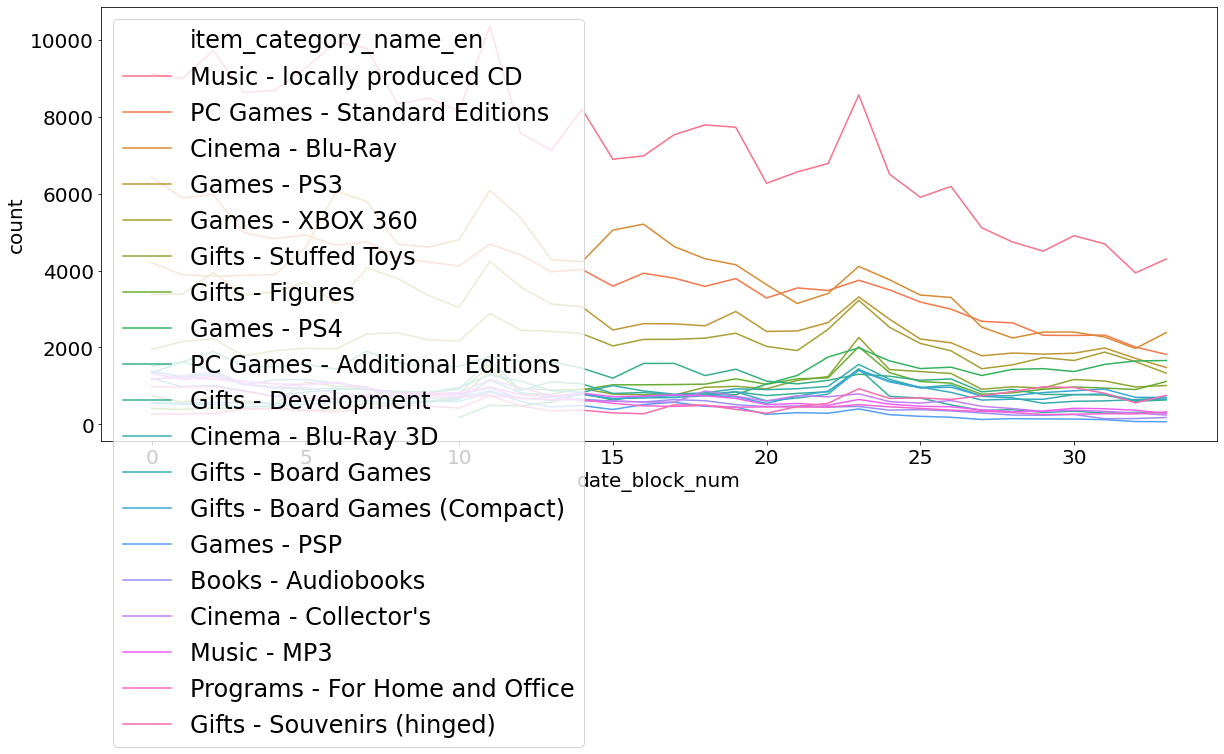

In [97]:
# 잘 팔리는 것들은 계속 잘 팔리는 듯.
sns.lineplot(x="date_block_num",y="count",hue="item_category_name_en",
            units="item_category_name_en",data=top20_item, estimator=None)

In [69]:
# 가게와 많이 팔린 상품 확인 (상위 10개)
sales_month.groupby(['shop_id','item_category_name_en'])['item_name_en'] \
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]

,shop_id,item_category_name_en,count
1366,25,Movie - DVD,18749
2999,54,Movie - DVD,17696
3135,57,Movie - DVD,17533
1735,31,Music - locally produced CD,16653
3073,56,Movie - DVD,13486
1548,28,Movie - DVD,13342
1372,25,Music - locally produced CD,12735
3193,58,Movie - DVD,11779
1554,28,Music - locally produced CD,11310
2299,42,Movie - DVD,11242


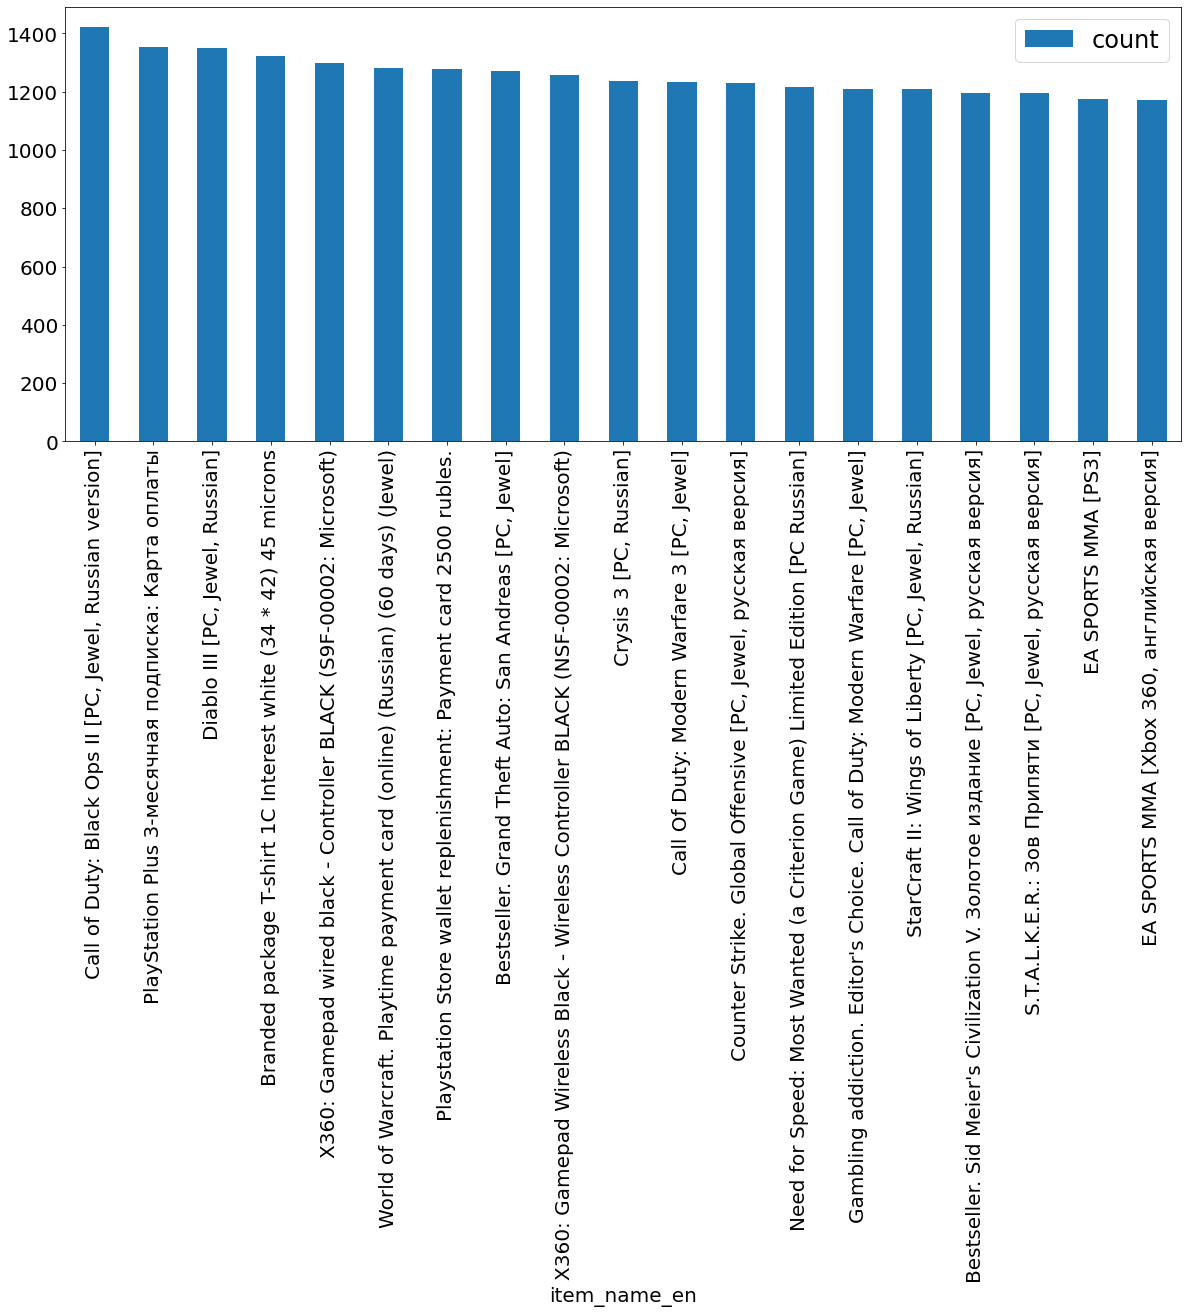

In [73]:
# 통틀어서 가장 많이 팔린 아이템 확인 (상위 20개)
# 거의 게임
sales_month.groupby(['item_name_en'])['item_id']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]\
            .plot.bar(x='item_name_en',y='count')

plt.show()

In [71]:
# 가게별로 많이 팔린 아이템 확인 (상위 20개)
sales_month.groupby(['shop_id','item_name_en'])['item_id']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]

,shop_id,item_name_en,count
37639,6,Playstation Store wallet replenishment: Paymen...,34
62313,12,Delivery (in Moscow),34
229735,31,КЛАССИКА Маленькие шедевры великих композитор...,34
227023,31,Soft toy SOYUZMULTFILM Donkey Eeyore,34
318140,46,X360: Gamepad wired black - Controller BLACK (...,34
132569,22,1С:Деньги 8,34
45812,7,Kinect Rush [Kinect only] [Xbox 360],34
108286,18,PlayStation Plus 3-месячная подписка: Карта оп...,34
154349,25,"Call of Duty: Black Ops II [PС, Jewel, Russian...",34
62315,12,Delivery to the point of issue (Boxberry),34


In [ ]:
# 가게별로 별차이 없으면 평균내버리기(평균낸걸로도 모델 돌려볼 예정)
sales_month_sum = sales_month.groupby(['date_block_num','item_id','item_name_en','item_category_id','item_category_name_en'], as_index=False)['item_cnt_day'].agg('sum')
sales_month_sum

In [ ]:
# Categorical Data 처리